In [1]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# emofilm_info_df = pd.read_csv('D:/Documents/emofilm/data/complete_info.csv')
emofilm_uk_df = pd.read_csv('D:/Documents/emofilm/data/emofilm_uk_df.csv')
emofilm_df = pd.read_csv('D:/Documents/emofilm_df.csv')
ravdess_df = pd.read_csv('D:/Documents/ravdess_df.csv')
savee_df = pd.read_csv('D:/Documents/savee_df.csv')
tess_df = pd.read_csv('D:/Documents/tess_df.csv')
cremad_df = pd.read_csv('D:/Documents/cremad_df.csv')

In [3]:
data_df = pd.concat([emofilm_uk_df, emofilm_df, ravdess_df, savee_df, tess_df, cremad_df],
                    axis=0, ignore_index=True)
data_df_no_uk = pd.concat([emofilm_df, ravdess_df, savee_df, tess_df, cremad_df],
                          axis=0, ignore_index=True)
data_df

emotion                                               path
0           fear  D:/Documents/emofilm/data/wav_corpus_uk/f_ans1...
1           fear  D:/Documents/emofilm/data/wav_corpus_uk/f_ans1...
2       contempt  D:/Documents/emofilm/data/wav_corpus_uk/f_dis0...
3       contempt  D:/Documents/emofilm/data/wav_corpus_uk/f_dis0...
4       contempt  D:/Documents/emofilm/data/wav_corpus_uk/f_dis1...
...          ...                                                ...
13298   contempt   D:/Documents/cremad/AudioWAV/1091_WSI_DIS_XX.wav
13299       fear   D:/Documents/cremad/AudioWAV/1091_WSI_FEA_XX.wav
13300  happiness   D:/Documents/cremad/AudioWAV/1091_WSI_HAP_XX.wav
13301    neutral   D:/Documents/cremad/AudioWAV/1091_WSI_NEU_XX.wav
13302    sadness   D:/Documents/cremad/AudioWAV/1091_WSI_SAD_XX.wav

[13303 rows x 2 columns]

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13303 entries, 0 to 13302
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  13303 non-null  object
 1   path     13303 non-null  object
dtypes: object(2)
memory usage: 208.0+ KB


In [5]:
emotions_number = data_df.emotion.unique().size
emotions_number

8

In [6]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def invert_polarity(data):
    return data * -1


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_df.path)[1]
data, sample_rate = librosa.load(path)

In [7]:
def extract_zcr(data):
    return librosa.feature.zero_crossing_rate(y=data)


def extract_chroma_stft(data, sr):
    return librosa.feature.chroma_stft(y=data, sr=sr)


def extract_mfcc(data, sr):
    return librosa.feature.mfcc(y=data, sr=sr)


def extract_rms(data):
    return librosa.feature.rms(y=data)


def extract_melspectrogram(data, sr):
    return librosa.feature.melspectrogram(y=data, sr=sr, n_fft=512)

In [8]:
# This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
import math
from numpy import ndarray


def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')


def fix_length(data: ndarray, length: int):
    fixed = data.reshape(len(data), 1)
    fixed = padding(fixed, length, 1)
    fixed = fixed.reshape(len(fixed))

    return fixed


def repeat_audio(data: ndarray, sr: int, duration_millis: int):

    length = int(duration_millis/1000*sr)
    n = math.ceil(duration_millis/1000*sr/len(data))
    fixed = np.tile(data, n)
    fixed = fixed[:length]

    return fixed

In [9]:
max_length = 110250
max_i = 14
sample_rate = 22050
max_duration_s = librosa.get_duration(path=data_df['path'][14])
required_duration_millis = 5000

width = 216  # 5 seconds of adio is 216
height = 128  # melspectrogram height is 128

duration = int(required_duration_millis/1000*sample_rate)

In [10]:
a, sr = librosa.load(data_df['path'][2])
a = librosa.util.fix_length(a, size=int(3 * sr))
print(a.shape, sr)

(66150,) 22050


width2 = int(required_duration_millis/1000*sr)
width2

(20, 130) (20,)


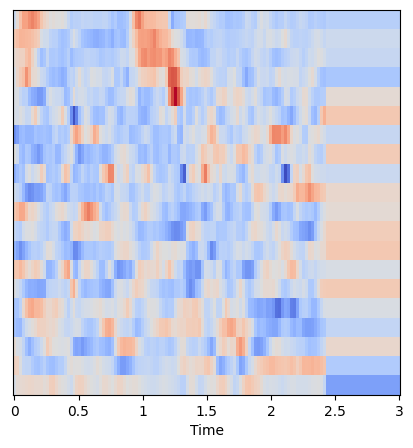

In [16]:
from sklearn.preprocessing import scale


mfccs = librosa.feature.mfcc(y=a, sr=sr)
mfccs = scale(mfccs, axis=1)
mfcc_m = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
print(mfccs.shape, mfcc_m.shape)

plt.figure(figsize=(5, 5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

(128, 130) (128,)


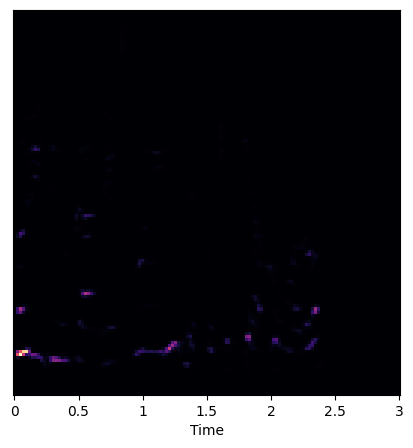

In [17]:
mel = librosa.feature.melspectrogram(y=a, sr=sr)
mel_m = np.mean(librosa.feature.melspectrogram(y=a, sr=sr).T, axis=0)
print(mel.shape, mel_m.shape)

plt.figure(figsize=(5, 5))
librosa.display.specshow(mel, sr=sr, x_axis='time')
plt.show()

In [18]:
import features_1d as ft


def extract_features(data):

    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path, augment=True):

    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    if (augment):

        noise_data = noise(data)
        res2 = extract_features(noise_data)
        result = np.vstack((result, res2))  # stacking vertically

        invert_data = invert_polarity(data)
        res3 = extract_features(invert_data)
        result = np.vstack((result, res3))  # stacking vertically
        return result

    result = np.reshape(result, (1, len(result)))

    return result


length_3s = 3 * 22050


def get_features_1d_v2(path, fixed_length=length_3s, augment=True):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)
    print(f'data: {data.shape}')
    data = librosa.util.fix_length(data, size=fixed_length)
    print(f'data: {data.shape}')
    # without augmentation
    res1 = ft.extract_features_1d_v2(data)
    result = np.array(res1)
    if (augment):
        noise_data = noise(data)
        res1 = ft.extract_features_1d_v2(noise_data)
        result = np.vstack((result, res1))  # stacking vertically
        invert_data = invert_polarity(data)
        res1 = ft.extract_features_1d_v2(invert_data)
        result = np.vstack((result, res1))  # stacking vertically
        return result

    result = np.reshape(result, (1, len(result)))
    return result

In [27]:
from sklearn.model_selection import train_test_split

train_df, test_l_df = train_test_split(data_df, test_size=0.3)
val_df, test_df = train_test_split(test_l_df, test_size=0.4)
train_df_no_uk, test_df_no_uk = train_test_split(data_df_no_uk, test_size=0.3)

print(f'train: {train_df.shape}\nval: {val_df.shape}\ntest: {test_df.shape}\n\ntest(no split): {test_l_df.shape}')

train: (9312, 2)
val: (2394, 2)
test: (1597, 2)

test(no split): (3991, 2)


In [20]:
def save_features(dataframe, path, augment=True):

    X, y = [], []

    for i, row in dataframe.iterrows():

        features = get_features(row['path'], augment)

        for f in features:

            X.append(f)

            y.append(row['emotion'])

    res_df = pd.DataFrame(X)

    res_df['labels'] = y

    res_df.to_csv(path, index=False)

    print(res_df.info())


def save_features_1d_v2(dataframe, path, augment=True):
    X, y = [], []
    for i, row in dataframe.iterrows():
        features = get_features_1d_v2(
            row['path'], fixed_length=int(3*22050), augment=augment)
        for f in features:
            X.append(f)
            y.append(row['emotion'])

    res_df = pd.DataFrame(X)
    res_df['labels'] = y

    res_df.to_csv(path, index=False)
    print(res_df.info())

## save v1

In [31]:
save_features(train_df, './features/features-train-all-v1.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27936 entries, 0 to 27935
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 34.7+ MB
None


In [33]:
save_features(test_df, './features/features-test-all-v1.csv', augment=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3991 entries, 0 to 3990
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 5.0+ MB
None


In [33]:
save_features(train_df_no_uk, './features/features-train-no-uk-v1.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27879 entries, 0 to 27878
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 34.7+ MB
None


In [34]:
save_features(
    test_df_no_uk, './features/features-test-no-uk-v1.csv', augment=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 5.0+ MB
None


In [35]:
save_features(
    emofilm_uk_df, './features/features-uk-only-v2.csv', augment=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 33.2+ KB
None


## Save v2

In [23]:
save_features_1d_v2(train_df, './features/features-train-all-1d-v2.csv')

data: (82403,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (87553,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (66217,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (52238,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (58123,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (52973,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (50766,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (62538,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (60331,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (44110,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (71367,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,

In [24]:
save_features_1d_v2(
    test_df, './features/features-test-all-1d-v2.csv', augment=False)

data: (131745,)
data: (66150,)
(130,)
(130,)
(130,)
data: (68424,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57388,)
data: (66150,)
(130,)
(130,)
(130,)
data: (55917,)
data: (66150,)
(130,)
(130,)
(130,)
data: (55917,)
data: (66150,)
(130,)
(130,)
(130,)
data: (65481,)
data: (66150,)
(130,)
(130,)
(130,)
data: (59595,)
data: (66150,)
(130,)
(130,)
(130,)
data: (48559,)
data: (66150,)
(130,)
(130,)
(130,)
data: (75045,)
data: (66150,)
(130,)
(130,)
(130,)
data: (59595,)
data: (66150,)
(130,)
(130,)
(130,)
data: (54252,)
data: (66150,)
(130,)
(130,)
(130,)
data: (83139,)
data: (66150,)
(130,)
(130,)
(130,)
data: (43699,)
data: (66150,)
(130,)
(130,)
(130,)
data: (46133,)
data: (66150,)
(130,)
(130,)
(130,)
data: (53709,)
data: (66150,)
(130,)
(130,)
(130,)
data: (58859,)
data: (66150,)
(130,)
(130,)
(130,)
data: (38084,)
data: (66150,)
(130,)
(130,)
(130,)
data: (58859,)
data: (66150,)
(130,)
(130,)
(130,)
data: (72103,)
data: (66150,)
(130,)
(130,)
(130,)
data: (55181,)
data: (66150,)


In [25]:
save_features_1d_v2(
    train_df_no_uk, './features/features-train-no-uk-1d-v2.csv')

data: (37579,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (56652,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (65481,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (52973,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (58123,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (41202,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (59595,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (32638,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (37656,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (32723,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (56558,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,

In [26]:
save_features_1d_v2(
    test_df_no_uk, './features/features-test-no-uk-1d-v2.csv', augment=False)

data: (80931,)
data: (66150,)
(130,)
(130,)
(130,)
data: (40466,)
data: (66150,)
(130,)
(130,)
(130,)
data: (80931,)
data: (66150,)
(130,)
(130,)
(130,)
data: (44881,)
data: (66150,)
(130,)
(130,)
(130,)
data: (101532,)
data: (66150,)
(130,)
(130,)
(130,)
data: (82403,)
data: (66150,)
(130,)
(130,)
(130,)
data: (48524,)
data: (66150,)
(130,)
(130,)
(130,)
data: (41834,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57388,)
data: (66150,)
(130,)
(130,)
(130,)
data: (58859,)
data: (66150,)
(130,)
(130,)
(130,)
data: (44145,)
data: (66150,)
(130,)
(130,)
(130,)
data: (44145,)
data: (66150,)
(130,)
(130,)
(130,)
data: (44937,)
data: (66150,)
(130,)
(130,)
(130,)
data: (50204,)
data: (66150,)
(130,)
(130,)
(130,)
data: (61495,)
data: (66150,)
(130,)
(130,)
(130,)
data: (40466,)
data: (66150,)
(130,)
(130,)
(130,)
data: (47087,)
data: (66150,)
(130,)
(130,)
(130,)
data: (62823,)
data: (66150,)
(130,)
(130,)
(130,)
data: (46356,)
data: (66150,)
(130,)
(130,)
(130,)
data: (45616,)
data: (66150,)


In [22]:
save_features_1d_v2(
    emofilm_uk_df, './features/features-uk-only-1d-v2.csv', augment=False)

data: (59361,)
data: (66150,)
(130,)
(130,)
(130,)
data: (27265,)
data: (66150,)
(130,)
(130,)
(130,)
data: (52806,)
data: (66150,)
(130,)
(130,)
(130,)
data: (26090,)
data: (66150,)
(130,)
(130,)
(130,)
data: (61786,)
data: (66150,)
(130,)
(130,)
(130,)
data: (31853,)
data: (66150,)
(130,)
(130,)
(130,)
data: (27299,)
data: (66150,)
(130,)
(130,)
(130,)
data: (39795,)
data: (66150,)
(130,)
(130,)
(130,)
data: (41638,)
data: (66150,)
(130,)
(130,)
(130,)
data: (59425,)
data: (66150,)
(130,)
(130,)
(130,)
data: (26189,)
data: (66150,)
(130,)
(130,)
(130,)
data: (34166,)
data: (66150,)
(130,)
(130,)
(130,)
data: (22601,)
data: (66150,)
(130,)
(130,)
(130,)
data: (77146,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57597,)
data: (66150,)
(130,)
(130,)
(130,)
data: (20974,)
data: (66150,)
(130,)
(130,)
(130,)
data: (33105,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57588,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57096,)
data: (66150,)
(130,)
(130,)
(130,)
data: (20505,)
data: (66150,)
(

## Save v3


In [16]:
length_2s = 2 * 22050

In [17]:
def extract_features_2d_v2(data, sr):
    result = np.array([])

    # stft = np.abs(librosa.stft(data))
    # stft_db = librosa.amplitude_to_db(stft, ref=np.max)
    # chroma_stft = librosa.feature.chroma_stft(y=data, sr=sr)
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    # mfcc = librosa.feature.mfcc(y=data, sr=sr)

    # print(f'shapes:\nstft_df\t{stft_db.shape}\nchroma_stft\t{chroma_stft.shape}\nmel\t{mel.shape}\nmfcc\t{mfcc.shape}')

    result = np.array(mel)
    # result = np.vstack((result, stft_db))
    # result = np.vstack((result, chroma_stft))
    # result = np.vstack((result, mel))
    # result = np.vstack((result, mfcc))

    return result

In [29]:
def get_features_2d_v2(path, fixed_length, augment=True):
    data, sample_rate = librosa.load(path)
    data = librosa.util.fix_length(data, size=fixed_length)
    res = extract_features_2d_v2(data, sample_rate)
    result = np.array(res)

    if (augment):
        noise_data = noise(data)
        res = extract_features_2d_v2(noise_data, sample_rate)
        result = np.vstack((result, res))

        invert_data = invert_polarity(data)
        res = extract_features_2d_v2(invert_data, sample_rate)
        result = np.vstack((result, res))
        return result

    result = np.reshape(result, (1, len(result)))
    return result


def get_features_2d_v3(path, fixed_length, extract_function, augment=True) -> list[ndarray]:
    result = []
    data, sample_rate = librosa.load(path)
    data = librosa.util.fix_length(data, size=fixed_length)
    image = extract_function(data, sample_rate)
    result.append(image)

    if (augment):
        image = extract_function(noise(data), sample_rate)
        result.append(image)

        image = extract_function(invert_polarity(data), sample_rate)
        result.append(image)

    return result

In [19]:
a = np.ones((2, 3))
b = np.zeros((2, 3))
c = np.vstack((a, b))

l = []
l.append(a)
l.append(b)

print(l)

[array([[1., 1., 1.],
       [1., 1., 1.]]), array([[0., 0., 0.],
       [0., 0., 0.]])]


In [32]:
def save_features_2d_v2(dataframe, path, augment=True):
    X, y = [], []
    for i, row in dataframe.iterrows():
        features = get_features_2d_v2(
            row['path'], fixed_length=length_2s, augment=augment)
        for f in features:
            X.append(f)
            y.append(row['emotion'])

    res_df = pd.DataFrame(X)
    res_df['labels'] = y
    res_df.to_csv(path, index=False)
    print(res_df.info())


def save_features_2d_v3(dataframe, path, fixed_length, extract_function, augment=True):
    X, y = [], []
    shape = ()
    for _, row in dataframe.iterrows():
        images = get_features_2d_v3(
            row['path'], fixed_length, extract_function=extract_function, augment=augment)
        for i in images:
            shape = i.shape
            X.append(i.flatten())
            y.append(row['emotion'])

    print(f'old samples: {len(dataframe)}\nnew samples: {len(X)}')
    res_df = pd.DataFrame(X)
    res_df['labels'] = y
    res_df.to_csv(path, index=False)
    print(res_df.info(), shape)

In [23]:
for i, row in data_df.head().iterrows():
    X, y = [], []
    images = get_features_2d_v3(
        row['path'], length_2s, extract_function=extract_melspectrogram, augment=False)
    for i in images:
        X.append(i.flatten())
        y.append(row['emotion'])

In [35]:
save_features_2d_v3(
    train_df,
    './features/features-train-all-2d-v3.csv',
    fixed_length=length_2s,
    extract_function=extract_melspectrogram,
    augment=True)

old samples: 9312
new samples: 27936
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27936 entries, 0 to 27935
Columns: 11137 entries, 0 to labels
dtypes: float64(11136), object(1)
memory usage: 2.3+ GB
None (128, 87)


In [34]:
save_features_2d_v3(
    val_df,
    './features/features-val-all-2d-v3.csv',
    fixed_length=length_2s,
    extract_function=extract_melspectrogram,
    augment=False)

old samples: 2394
new samples: 2394
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Columns: 11137 entries, 0 to labels
dtypes: float32(11136), object(1)
memory usage: 101.7+ MB
None (128, 87)


In [33]:
save_features_2d_v3(
    test_df,
    './features/features-test-all-2d-v3.csv',
    fixed_length=length_2s,
    extract_function=extract_melspectrogram,
    augment=False)

old samples: 1597
new samples: 1597
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Columns: 11137 entries, 0 to labels
dtypes: float32(11136), object(1)
memory usage: 67.9+ MB
None (128, 87)


In [ ]:
# save_features_2d_v2(
#     train_df_no_uk, './features/features-train-no-uk-2d-v2.csv')
# save_features_2d_v2(
#     test_df_no_uk, './features/features-test-no-uk-2d-v2.csv', augment=False)
# save_features_2d_v2(
#     emofilm_uk_df, './features/features-uk-only-2d-v2.csv', augment=False)